<a class="anchor" id="1"></a>
# <p style="padding:10px;background-color:#61868c;margin:0;color:#ffffff;font-family:Arial, sans-serif;font-size:80%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Importing Libraries</p>

In [51]:
# Data Handling
import numpy as np
import csv
import pickle
import os

# Algorithm
from sklearn.neighbors import KNeighborsClassifier

# Visualization
import matplotlib.pyplot as plt

# Train, test, split
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Computer Vision
import cv2

# Utilities
import time
from datetime import datetime

# Windows-Specific Automation
from win32com.client import Dispatch

In [52]:
# Automated voice for when attendance is taken
def speak(str1):
    speak = Dispatch("SAPI.SpVoice")
    speak.Voice = speak.GetVoices("Name=Microsoft Zira Desktop").Item(0)
    speak.Speak(str1)

<a class="anchor" id="2"></a>
# <p style="padding:10px;background-color:#61868c;margin:0;color:#ffffff;font-family:Arial, sans-serif;font-size:80%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Setup: Video Capture, Face Detection, and Data Loading</p>

In [53]:
# Capture camera video frame (0- laptop camera | 1- external web camera)
video = cv2.VideoCapture(0)
facedetection = cv2.CascadeClassifier(
    r'data\haarcascade_frontalface_default.xml')

# Load the faces and name data
with open('data/names.pkl', 'rb') as f:
    LABELS = pickle.load(f)
with open('data/faces_list.pkl', 'rb') as f:
    FACES = pickle.load(f)

<a class="anchor" id="3"></a>
# <p style="padding:10px;background-color:#61868c;margin:0;color:#ffffff;font-family:Arial, sans-serif;font-size:80%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Splitting the Data into Training and Testing Sets</p>

In [54]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(FACES, LABELS, test_size=0.2, random_state=42)

print("Training Set Size:", len(X_train))
print("Testing Set Size:", len(X_test))

Training Set Size: 120
Testing Set Size: 30


<a class="anchor" id="4"></a>
# <p style="padding:10px;background-color:#61868c;margin:0;color:#ffffff;font-family:Arial, sans-serif;font-size:80%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Train K-Nearest Neighbors Classifier</p>

In [55]:
# Train the K-Nearest Neighbors (KNN) model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(FACES, LABELS)  # FACES: 2D array of face embeddings, LABELS: corresponding names

print("Model trained successfully!")

Model trained successfully!


In [56]:
bgDisplay = cv2.imread("backgrounds/bg-log_attendance.png")

# Columns to be displayed in attendance csv
COL_NAMES = ['NAME', 'DATE', 'TIME']

<a class="anchor" id="5"></a>
# <p style="padding:10px;background-color:#61868c;margin:0;color:#ffffff;font-family:Arial, sans-serif;font-size:80%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Testing the Model</p>

In [57]:
# Test the model on the test set
y_pred = knn.predict(X_test)

print("Predictions:", y_pred)

Predictions: ['Prince' 'Princess' 'Milain' 'Prince' 'Prince' 'Princess' 'Prince'
 'Milain' 'Prince' 'Prince' 'Milain' 'Princess' 'Princess' 'Princess'
 'Princess' 'Prince' 'Milain' 'Prince' 'Prince' 'Milain' 'Princess'
 'Milain' 'Princess' 'Milain' 'Milain' 'Milain' 'Milain' 'Milain'
 'Princess' 'Princess']


<a class="anchor" id="9"></a>
# <p style="padding:10px;background-color:#61868c;margin:0;color:#ffffff;font-family:Arial, sans-serif;font-size:80%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Face Visualization Prediction</p>

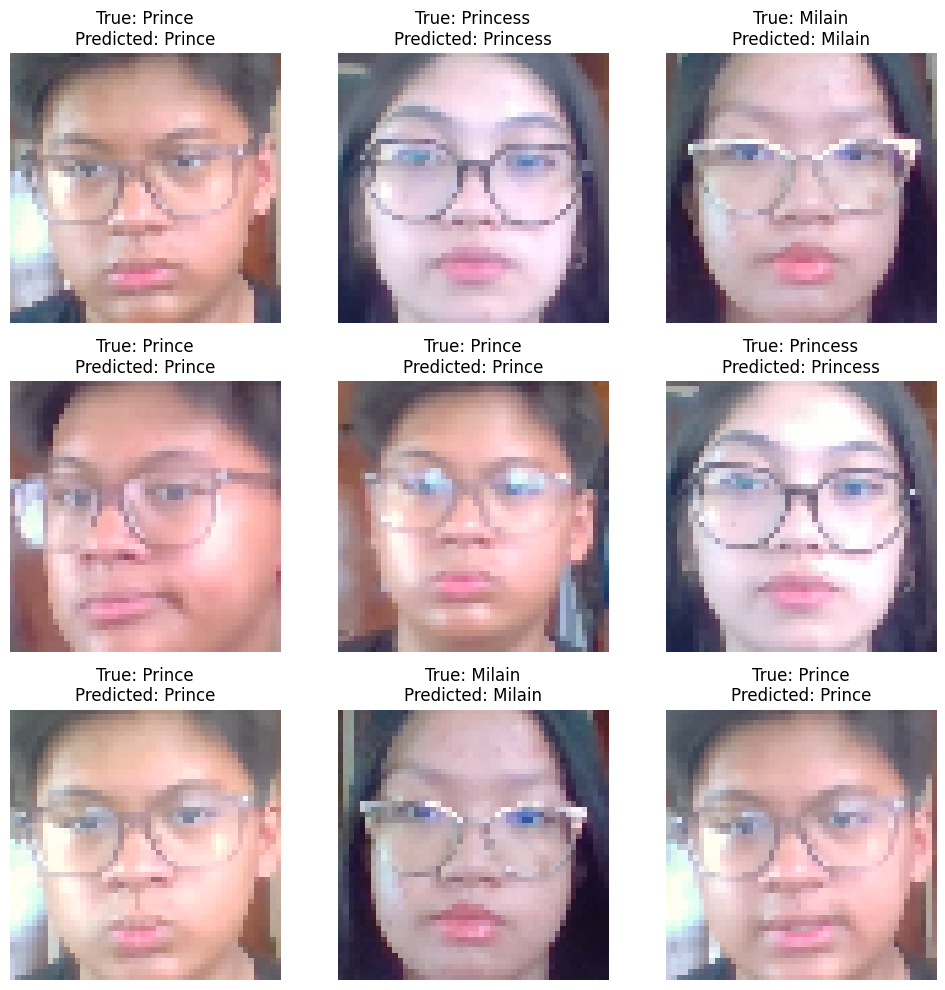

In [58]:
# Visualize some predictions with the corresponding faces
def display_face_with_label(face, true_label, predicted_label, index):
    """Display a single face with the true and predicted label."""
    face = face.reshape(50, 50, 3)  # Reshape the flattened face
    plt.imshow(cv2.cvtColor(face.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis('off')
    # plt.savefig(f"evaluation_face_{index}.png") # Optional: Save each evaluation image for records

# Show a few predictions and their corresponding faces
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 samples
    plt.subplot(3, 3, i + 1)
    display_face_with_label(X_test[i], y_test[i], y_pred[i], i)

plt.tight_layout()
plt.show()

<a class="anchor" id="6"></a>
# <p style="padding:10px;background-color:#61868c;margin:0;color:#ffffff;font-family:Arial, sans-serif;font-size:80%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Real-Time Face Detection and Recognition</p>

In [59]:
while True:
    ret, frame = video.read()

    # Mirror the frame horizontally for better usability
    frame = cv2.flip(frame, 1)

    # Convert frame to greyscale for better face detection
    grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facedetection.detectMultiScale(grayscale, 1.3, 5)

    for (x, y, w, h) in faces:
        # Preprocess detected face for prediction
        crop_image = frame[y:y+h, x:x+w, :]
        resized_image = cv2.resize(crop_image, (50, 50)).flatten().reshape(1, -1)

        # Prediction: Use KNN to predict the face
        output = knn.predict(resized_image)  # Returns the predicted label (name)

        # Record timestamp and date
        ts = time.time()
        date = datetime.fromtimestamp(ts).strftime("%d-%m-%Y")
        timestamp = datetime.fromtimestamp(ts).strftime("%H:%M %p")

        # Check if attendance file exists
        exist = os.path.isfile("attendance/Attendance_" + date + ".csv")

        # Draw rectangle around face and display predicted name
        cv2.rectangle(frame, (x, y), (x+w, y+h), (203, 193, 37), 2)
        cv2.rectangle(frame, (x, y-40), (x+w, y), (203, 193, 37), -1)
        cv2.putText(frame, str(output[0]), (x + 11, y-11),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Prepare attendance data
        attendance = [str(output[0]), str(date), str(timestamp)]

    bgDisplay[142:142 + 480, 78:78 + 640] = frame

    cv2.imshow("Face Collection", bgDisplay)

    k = cv2.waitKey(1)

    # If 'a' is pressed, mark attendance
    if k == ord('a'):
        speak("Attendance Taken..")
        time.sleep(1)

        if exist:
            # Append to the existing file
            with open("attendance/Attendance_" + date + ".csv", "+a") as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(attendance)
        else:
            # Create new file and write attendance
            with open("attendance/Attendance_" + date + ".csv", "+a") as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(COL_NAMES)
                writer.writerow(attendance)

    # Exit the loop if 'q' is pressed
    if k == ord('q'):
        break

In [60]:
# Release the video and close all OpenCV windows
video.release()
cv2.destroyAllWindows()

<a class="anchor" id="7"></a>
# <p style="padding:10px;background-color:#61868c;margin:0;color:#ffffff;font-family:Arial, sans-serif;font-size:80%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Evaluating the Model</p>

In [61]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy Score: {100 * accuracy: 2f}%")

# Generate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report: \n", report)

Model Accuracy Score:  100.000000%
Classification Report: 
               precision    recall  f1-score   support

      Milain       1.00      1.00      1.00        11
      Prince       1.00      1.00      1.00         9
    Princess       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



<a class="anchor" id="8"></a>
# <p style="padding:10px;background-color:#61868c;margin:0;color:#ffffff;font-family:Arial, sans-serif;font-size:80%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Generating & Displaying the Confusion Matrix Report</p>

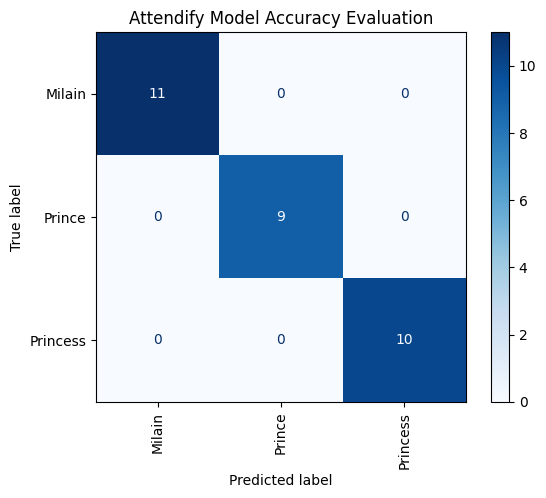

In [62]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap='Blues', xticks_rotation='vertical')

# Show the confusion matrix
plt.title("Attendify Model Accuracy Evaluation")
plt.show()